In [190]:
pip install --upgrade ydata-profiling

python(19508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


In [191]:
#Importing all the Necessary Libraries
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

**This section defines the file paths for the HUPA-UC Diabetes Dataset and various CSV outputs.**

In [193]:
#Downloads/PyQuesters_Python_Hackathon/HUPA-UC Diabetes Dataset
path = "HUPA-UC Diabetes Dataset/"
demographic_path = path + "T1DM_patient_sleep_demographics_with_race.csv"
all_patients_path = path + "ALL_PATIENTS.csv"
modified_demographic_path = path+"DEMOGRAPHIC.csv"
patients_demographic_path = path +"PATIENTS_WITH_DEMOGRAPHIC.csv"

**This code reads all CSV files containing patient data, adds a patient_id column based on the filename, concatenates them into a single DataFrame, and saves it as a new CSV file.**
**Key Steps:**

- **List CSV Files:** Use glob to get all patient CSV files starting with "H".

- **Read & Annotate:** Read each CSV and add a patient_id column extracted from the filename.

- **Concatenate DataFrames:** Merge all individual DataFrames into one using pd.concat().

- **Save CSV:** Export the combined DataFrame to a CSV file without the index column.

In [195]:
#Creating a dataframe by merging all csv files having patient data
csv_files = glob.glob(os.path.join(path,"H*.csv"))
print(csv_files)
df_list =[]
for file in csv_files:
    patientId = os.path.basename(file).split(".")[0]
    df = pd.read_csv(file,sep=";")
    df["patient_id"] = patientId
    df_list.append(df)
patients_df = pd.concat(df_list, ignore_index = True)
patients_df.columns
patients_df.to_csv(all_patients_path,index=False)


['HUPA-UC Diabetes Dataset/HUPA0023P.csv', 'HUPA-UC Diabetes Dataset/HUPA0019P.csv', 'HUPA-UC Diabetes Dataset/HUPA0015P.csv', 'HUPA-UC Diabetes Dataset/HUPA0003P.csv', 'HUPA-UC Diabetes Dataset/HUPA0002P.csv', 'HUPA-UC Diabetes Dataset/HUPA0014P.csv', 'HUPA-UC Diabetes Dataset/HUPA0018P.csv', 'HUPA-UC Diabetes Dataset/HUPA0022P.csv', 'HUPA-UC Diabetes Dataset/HUPA0005P.csv', 'HUPA-UC Diabetes Dataset/HUPA0025P.csv', 'HUPA-UC Diabetes Dataset/HUPA0009P.csv', 'HUPA-UC Diabetes Dataset/HUPA0024P.csv', 'HUPA-UC Diabetes Dataset/HUPA0004P.csv', 'HUPA-UC Diabetes Dataset/HUPA0028P.csv', 'HUPA-UC Diabetes Dataset/HUPA0007P.csv', 'HUPA-UC Diabetes Dataset/HUPA0011P.csv', 'HUPA-UC Diabetes Dataset/HUPA0027P.csv', 'HUPA-UC Diabetes Dataset/HUPA0026P.csv', 'HUPA-UC Diabetes Dataset/HUPA0010P.csv', 'HUPA-UC Diabetes Dataset/HUPA0006P.csv', 'HUPA-UC Diabetes Dataset/HUPA0021P.csv', 'HUPA-UC Diabetes Dataset/HUPA0001P.csv', 'HUPA-UC Diabetes Dataset/HUPA0017P.csv', 'HUPA-UC Diabetes Dataset/HUPA001

**Data Cleaning and Standardization**
**Rename columns according to HUPA standard naming conventions, and save the modified DataFrame to a new CSV file.**

**Key Steps:**

- **Read CSV:** Load the demographic dataset into a Pandas DataFrame.
- **Rename Columns:** Align column names with HUPA naming standards for consistency.
- **Save CSV:** Export the modified DataFrame to a new CSV without the index column.


In [197]:
#Renamed Column names as per the HUPA standred naming conventions and created new csv filedemographic_df = pd.read_csv(demographic_path)
demographic_df.rename(columns={"Patient_ID":"patient_id","Age":"age","Gender":"gender","Race":"race","Average Sleep Duration (hrs)":"avg_sleep_duration_hrs","Sleep Quality (1-10)":"sleep_quality_score","% with Sleep Disturbances":"sleep_disturbances_percentage"},inplace = True)
demographic_df.columns
demographic_df.to_csv(modified_demographic_path, index=False)

**This code merges the combined patient dataset with the demographic dataset on patient_id and saves the resulting DataFrame as a new CSV file.**
**Key Steps:**

- **Merge DataFrames:** Use pd.merge() with how="inner" to combine patient and demographic datasets based on patient_id.

- **Save CSV:** Export the merged DataFrame to a CSV file without including the index column.

- **Verify Columns:** Check the resulting columns to ensure all patient and demographic data are included.

In [199]:
#Dataframe for merged allpatients and demographic data and created csv file
patients_demo_df = pd.merge(patients_df,demographic_df, on ="patient_id", how="inner")
patients_demo_df.to_csv(patients_demographic_path, index=False)
patients_demo_df.columns

Index(['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
       'bolus_volume_delivered', 'carb_input', 'patient_id', 'age', 'gender',
       'race', 'avg_sleep_duration_hrs', 'sleep_quality_score',
       'sleep_disturbances_percentage'],
      dtype='object')

**Data Cleaning and Standardization**
**2. Time Conversion**
**Key Steps:**
- **a. The time column is converted from text (object) to proper datetime format using pd.to_datetime() so as to sort, filter, or calculate with it meaningfully.If time stays as a string (object), Python just sees it as plain text**
- 
- **b. Any invalid or unrecognized time values are set to NaT (Not a Time) using errors='coerce'. c. A new column Patient_ID is added to uniquely identify each participant, derived from the filename.**

In [201]:

patients_demo_df['time'] = pd.to_datetime(patients_demo_df['time'], errors='coerce')



**Data Cleaning and Standardization**

**3.Insulin Dose Cleaning**
**Key Steps:**
    - **a. The column bolus_volume_delivered (insulin dose administered) is checked for invalid negative values.**
    - **Since negative doses are not meaningful, all negative values are replaced with 0**
    
    

In [203]:
patients_demo_df.loc[patients_demo_df['bolus_volume_delivered'] < 0, 'bolus_volume_delivered'] = 0

**Data Cleaning and Standardization**
**4. Heart Rate**
**Key Steps:**
    - **a. Rounded heart_rate values to the nearest integer.**
    - **b. This ensures values are clinically interpretable, since heart rate is typically measured in whole beats per minute (BPM).**

In [205]:
## Round heart_rate to nearest integer for Clinical/medical analysis 
patients_demo_df['heart_rate'] = patients_demo_df['heart_rate'].round(0).astype(int)

**Data Cleaning and Standardization**
**5. Basal Insulin Rate**
**Key Steps:**
    - **a. Created a new column basal_rate_cleaned by adjusting basal_rate to realistic increments of 0.025 units/hour (a common resolution in insulin pumps).**
    - **b.Very small noise values (< 0.025) were clipped to 0 to avoid meaningless fluctuations.**

In [207]:
# changing to  realistic basal_rate for modeling/analysis.
patients_demo_df['basal_rate_cleaned'] = (patients_demo_df['basal_rate'] / 0.025).round() * 0.025
# clip tiny noise values
patients_demo_df.loc[patients_demo_df['basal_rate_cleaned'] < 0.025, 'basal_rate_cleaned'] = 0

**Data Cleaning and Standardization**
**6. Calories**
**Key Steps:**
    - **a. Rounded calories to 1 decimal place for readability and consistent reporting.**

In [209]:
#Round calories to 1 decimal place
patients_demo_df['calories'] = patients_demo_df['calories'].round(1)

**Data Cleaning and Standardization**
**7. Glucose**
**Key Steps:**
    - **a. Rounded glucose to 1 decimal place for easier comparison and clinical interpretation.**

In [211]:
#Round glucose to 1 decimal place
patients_demo_df['glucose'] = patients_demo_df['glucose'].round(1)

In [212]:
patients_demo_df.shape
print(patients_demo_df.columns)
missingvalues_percentage = patients_demo_df.isnull().mean() * 100

Index(['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
       'bolus_volume_delivered', 'carb_input', 'patient_id', 'age', 'gender',
       'race', 'avg_sleep_duration_hrs', 'sleep_quality_score',
       'sleep_disturbances_percentage', 'basal_rate_cleaned'],
      dtype='object')


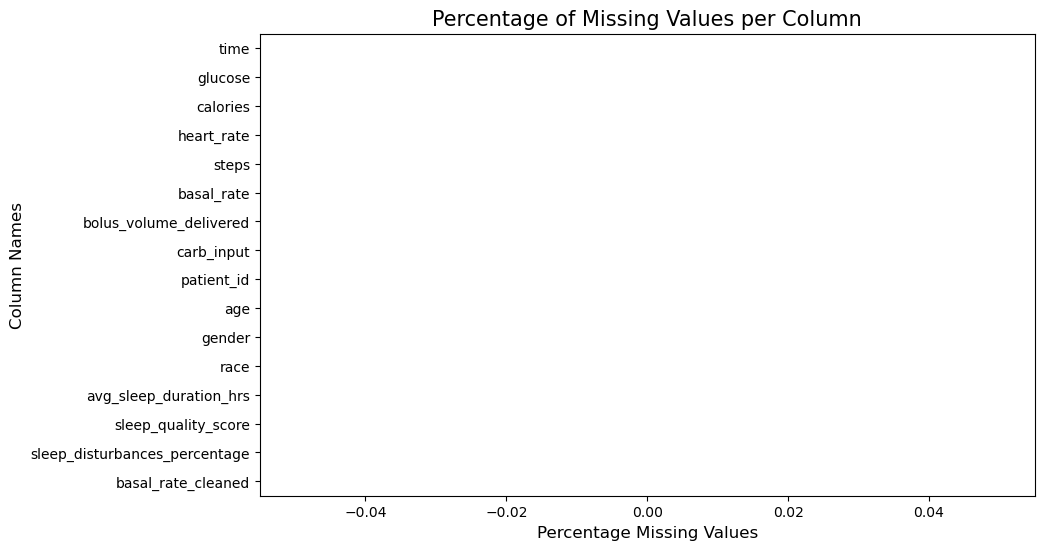

In [213]:
# Convert Series → DataFrame
missing_df = missingvalues_percentage.reset_index()
missing_df.columns = ["column", "missing_pct"]

plt.figure(figsize=(10,6))
sns.barplot(data=missing_df, x="missing_pct", y="column", color="skyblue")
plt.title("Percentage of Missing Values per Column", fontsize=15)
plt.xlabel("Percentage Missing Values", fontsize=12)
plt.ylabel("Column Names", fontsize=12)
plt.show()


In [214]:
cleaned_df = pd.DataFrame(patients_demo_df)
cleaned_df.to_csv("cleaned_df_output.csv")

**Data Quality Report**

**This Python function generates a comprehensive data quality report for a given DataFrame. It checks for missing values, duplicates, data types, numeric ranges, and impossible or outlier values.**
**Key Checks Performed:**
    - **Dataset shape – rows and columns.**
    - **Missing values – column-wise count.**
    - **Duplicate rows – total duplicates in the dataset.**
    - **Data types – helps ensure correct types for analysis.**
    - **Patient ID uniqueness – checks for repeated patients.**
    - **Numeric summary – min, max, mean values of numeric columns.**
    - **Time range – earliest and latest timestamps.**
    - **Impossible/outlier values – negative values or unrealistic glucose readings.**
    - **Value ranges – ensures columns like glucose, steps, heart rate, and calories fall in reasonable ranges**

In [216]:
import pandas as pd

def data_quality_report(df):
    print("DATA QUALITY REPORT")
    print("="*50)
    
    # Shape
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("="*50)
    
    # Missing values
    print("*"*50)
    print("\n Check for Missing Values:")
    print("*"*50)
    print("\n Number of missing column values are:\n", df.isnull().sum())
    
    # Duplicates
    print("*"*50)
    print("\n Check for Duplicate Rows:")
    print("*"*50)
    print("\n Number of duplicate rows  are :", df.duplicated().sum())
    
    # Data types
    print("*"*50)
    print("\n Check for Column Data Types:")
    print("*"*50)
    print(df.dtypes)
    
    # Unique Patient IDs
    if "Patient_ID" in df.columns:
        print("*"*50)
        print("\n Check for Patient IDs uniqueness and number of records:")
        print("*"*50)
        print("Number of Unique Patient IDs:", df['Patient_ID'].nunique())
        print("Total patient records are  :", len(df))
    
    # Numeric ranges
    print("*"*50)
    print("\n Check for Numeric Column Summary:")
    print("*"*50)
    print(df.describe().T[['min', 'max', 'mean']])
    
    # Time range
    if "time" in df.columns:
        print("*"*50)
        print("\n Check for Time Range to check if time is continuous :")
        print("*"*50)
        print("Earliest time :", df['time'].min())
        print("Latest time  :", df['time'].max())
        
    
    #Check for impossible or outlier values
    print("*"*50)
    print("\n Check for Impossible or outlier values:")
    print("*"*50)
    print("Negative glucose values:", (df['glucose'] < 0).sum())
    print("Negative steps values:", (df['steps'] < 0).sum())
    print("Negative calories values:", (df['calories'] < 0).sum())
    print("Negative heart_rate values:", (df['heart_rate'] < 0).sum())
    print("Negative glucose:", (patient_df['glucose'] < 0).sum())
    print("Unrealistic glucose > 600:", (patient_df['glucose'] > 600).sum())
    print("Negative Insulin dose administered(bolus_volume_delivered) values:", (df['bolus_volume_delivered'] < 0).sum())
    

    #check for range of values
    print("*"*50)
    print("\n Check for range of  values for Glucose Hear rate ,Calories ,Insulin dose administered (units) and Steps:")
    print("*"*50)
    print("Glucose range:", patient_df['glucose'].min(), "-", patient_df['glucose'].max())
    print("Heart rate range:", patient_df['heart_rate'].min(), "-", patient_df['heart_rate'].max())
    print("Calories range:", patient_df['calories'].min(), "-", patient_df['calories'].max())
    print("Steps range:", patient_df['steps'].min(), "-", patient_df['steps'].max())
    print("Insulin dose administered (units) range:", patient_df['basal_rate'].min(), "-", patient_df['basal_rate'].max())
    print("="*50)

    print("DATA QUALITY REPORT Completed")

# Example usage
data_quality_report(patients_demo_df)


DATA QUALITY REPORT
Rows: 309392, Columns: 16
**************************************************

 Check for Missing Values:
**************************************************

 Number of missing column values are:
 time                             0
glucose                          0
calories                         0
heart_rate                       0
steps                            0
basal_rate                       0
bolus_volume_delivered           0
carb_input                       0
patient_id                       0
age                              0
gender                           0
race                             0
avg_sleep_duration_hrs           0
sleep_quality_score              0
sleep_disturbances_percentage    0
basal_rate_cleaned               0
dtype: int64
**************************************************

 Check for Duplicate Rows:
**************************************************

 Number of duplicate rows  are : 0
*********************************************